In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/earthquake-classification/test_values.csv
/kaggle/input/earthquake-classification/train_labels.csv
/kaggle/input/earthquake-classification/train_values.csv
/kaggle/input/esqk-ffnn-res/ffnn_y_pred_prob.csv
/kaggle/input/esqk-ffnn-res/ffnn_y_pred_prob_te.csv


In [2]:
# import cupy as cp
# import cudf
# import sys
# !cp ../input/rapids/rapids.21.06 /opt/conda/envs/rapids.tar.gz
# !cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
# sys.path += ["/opt/conda/envs/rapids/lib/python3.7/site-packages"]
# sys.path += ["/opt/conda/envs/rapids/lib/python3.7"]
# sys.path += ["/opt/conda/envs/rapids/lib"] 

In [3]:
!pip install --upgrade scikit-learn
import pandas as pd
import numpy as np
from typing import Callable
from sklearn.preprocessing import MinMaxScaler, StandardScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 26.9 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [5]:
# defination of different types of columns

id_columns = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_columns = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']

categorical_str_columns = ['land_surface_condition', 'foundation_type', 'roof_type',
                           'ground_floor_type', 'other_floor_type', 'position', 'legal_ownership_status',
                           'plan_configuration']

categorical_int_columns = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                           'has_superstructure_cement_mortar_stone','has_superstructure_mud_mortar_brick',
                           'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
                           'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
                           'has_superstructure_rc_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use',
                           'has_secondary_use_agriculture', 'has_secondary_use_hotel',
                           'has_secondary_use_rental', 'has_secondary_use_institution',
                           'has_secondary_use_school', 'has_secondary_use_industry',
                           'has_secondary_use_health_post', 'has_secondary_use_gov_office',
                           'has_secondary_use_use_police', 'has_secondary_use_other']

## 训练集处理

In [6]:
train_values = pd.read_csv("/kaggle/input/earthquake-classification/train_values.csv")
train_labels = pd.read_csv("/kaggle/input/earthquake-classification/train_labels.csv")
df = train_values.merge(train_labels, on="building_id",how="left")
geos = df[['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']]
df.drop(id_columns,axis=1,inplace=True)
X,y = df.drop(["damage_grade"],axis=1),df["damage_grade"]

In [7]:
df.isna().sum()

count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engineered      0
has_superstructure_rc_engineered          0
has_superstructure_other                  0
legal_ownership_status          

In [8]:
df.head(5)

,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,2,30,6,5,t,r,n,f,q,t,...,0,0,0,0,0,0,0,0,0,3
1,2,10,8,7,o,r,n,x,q,s,...,0,0,0,0,0,0,0,0,0,2
2,2,10,5,5,t,r,n,f,x,t,...,0,0,0,0,0,0,0,0,0,3
3,2,10,6,5,t,r,n,f,x,s,...,0,0,0,0,0,0,0,0,0,2
4,3,30,8,9,t,r,n,f,x,s,...,0,0,0,0,0,0,0,0,0,3


### 生成虚拟变量（回归）和独热编码（其他模型）

In [9]:
# get the dummies for features in categorical_str_columns

## get the dummies data for regression(drop first)
X_reg = pd.get_dummies(data=X, columns=categorical_str_columns, drop_first=True, sparse=True)

## get the one hot data for other models
X_class = pd.get_dummies(data=X, columns=categorical_str_columns, drop_first=False, sparse=True)
y_dummy = pd.get_dummies(y,prefix="class")

In [10]:
X_reg.dtypes

count_floors_pre_eq                                     int64
age                                                     int64
area_percentage                                         int64
height_percentage                                       int64
has_superstructure_adobe_mud                            int64
has_superstructure_mud_mortar_stone                     int64
has_superstructure_stone_flag                           int64
has_superstructure_cement_mortar_stone                  int64
has_superstructure_mud_mortar_brick                     int64
has_superstructure_cement_mortar_brick                  int64
has_superstructure_timber                               int64
has_superstructure_bamboo                               int64
has_superstructure_rc_non_engineered                    int64
has_superstructure_rc_engineered                        int64
has_superstructure_other                                int64
count_families                                          int64
has_seco

### 分割测试集与训练集

In [11]:
from sklearn.model_selection import train_test_split
X_reg_train,X_reg_test,X_class_train,X_class_test,y_train,y_test,y_dummy_train,y_dummy_test,geos_train,geos_test = train_test_split(X_reg,X_class,y,y_dummy,geos,test_size=0.2,random_state=42)

In [12]:
print(X_reg_train.shape)
print(X_reg_test.shape)
print(X_class_train.shape)
print(X_class_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(208480, 57)
(52121, 57)
(208480, 65)
(52121, 65)
(208480,)
(52121,)
damage_grade
2    118772
3     69754
1     19954
Name: count, dtype: int64
damage_grade
2    29487
3    17464
1     5170
Name: count, dtype: int64


### 用 TargetEncoder 处理 geo_id

In [13]:
!pip install --upgrade scikit-learn

In [14]:
from sklearn.preprocessing import TargetEncoder
target_encoder = TargetEncoder(target_type="continuous",random_state=42)
geos_train = target_encoder.fit_transform(geos_train,y_train)
geos_test = target_encoder.transform(geos_test)
scaler = StandardScaler()
geos_train = scaler.fit_transform(geos_train)
geos_test = scaler.transform(geos_test)

In [15]:
print(geos_train[:5])
print(geos_test[:5])

[[-1.03726829 -1.57208263 -0.60597578]
 [-0.26611576  0.61692117  0.25786245]
 [ 0.20395014  1.14698755  1.12361389]
 [ 0.203842   -0.28595735 -0.38113132]
 [ 1.93388762  1.98894244  1.91996996]]
[[ 0.36124928  0.65076136  0.15722944]
 [-0.84131605 -1.7429001  -1.87396038]
 [-1.76617593 -1.99107571 -1.79359998]
 [ 0.84005131 -0.248443   -0.33061036]
 [-0.25541953 -0.3398393  -0.44592924]]


### 标准化

In [16]:
class Standardizer(object):
    
    def __init__(self, target_columns: list=numerical_columns, standard_method: Callable=StandardScaler):
        self.target_columns = numerical_columns
        self.model = standard_method()
        pass
        
    def fit(self, data: pd.DataFrame):
        df_standard = data[self.target_columns]
        self.model.fit(df_standard)
        pass
    
    def transform(self, data: pd.DataFrame):
        data_list = []
        data_list.append(data.drop(self.target_columns, axis=1))
        
        df_standard = data[self.target_columns]
        data_list.append(pd.DataFrame(self.model.transform(df_standard), columns=df_standard.columns, index=df_standard.index))
        
        return pd.concat(data_list, axis=1)
    
    def fit_transform(self, data: pd.DataFrame):
        data_list = []
        data_list.append(data.drop(self.target_columns, axis=1))
        df_standard = data[self.target_columns]
        data_list.append(pd.DataFrame(self.model.fit_transform(df_standard), columns=df_standard.columns, index=df_standard.index))
        new_df = pd.concat(data_list, axis=1)
        return new_df

In [17]:
standardizer_reg = Standardizer()
X_reg_train = standardizer_reg.fit_transform(data=X_reg_train)
X_reg_test = standardizer_reg.transform(data=X_reg_test)
standardizer_class = Standardizer()
X_class_train = standardizer_class.fit_transform(data=X_class_train)
X_class_test = standardizer_class.transform(data=X_class_test)

### LASSO AND RIDGE

In [18]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
import numpy as np
X_reg_train = np.hstack((X_reg_train, geos_train))
X_reg_test = np.hstack((X_reg_test, geos_test))

In [19]:

lb = LabelBinarizer()
lb.fit(y_train)
y_train_bin = lb.transform(y_train)

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [20]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

# Perform logistic regression for each category
classifiers = []
for i in range(3):
    logreg = LogisticRegression(penalty='l1', solver='saga')
    grid_search = GridSearchCV(estimator=logreg, param_grid=parameters, cv=5, scoring='accuracy')
    grid_search.fit(X_reg_train, y_train_bin[:, i])
    classifiers.append(grid_search.best_estimator_)

    # Output the optimal C value and corresponding accuracy
    print(f"For category {i+1}, the optimal C value is: ", grid_search.best_params_["C"])
    print(f"The corresponding accuracy is: ", grid_search.best_score_)

# For new input x, choose the category i that maximizes pˆi(x) as the prediction result
probabilities = np.array([clf.predict_proba(X_reg_test)[:, 1] for clf in classifiers]).T
predictions = np.argmax(probabilities, axis=1) + 1

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy of logistic regression: ", accuracy)

For category 1, the optimal C value is:  1
The corresponding accuracy is:  0.9216423637759018
For category 2, the optimal C value is:  1000
The corresponding accuracy is:  0.6968390253261704
For category 3, the optimal C value is:  1
The corresponding accuracy is:  0.8011080199539524
Accuracy of logistic regression:  0.7172732679726023


Accuracy:  0.7172732679726023
Confusion Matrix: 
 [[ 1461  3573   136]
 [  643 25370  3474]
 [   38  6872 10554]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.68      0.28      0.40      5170
           2       0.71      0.86      0.78     29487
           3       0.75      0.60      0.67     17464

    accuracy                           0.72     52121
   macro avg       0.71      0.58      0.61     52121
weighted avg       0.72      0.72      0.70     52121

Classification Report: 
               precision    recall  f1-score   support

           1       0.68      0.28      0.40      5170
           2       0.71      0.86      0.78     29487
           3       0.75      0.60      0.67     17464

    accuracy                           0.72     52121
   macro avg       0.71      0.58      0.61     52121
weighted avg       0.72      0.72      0.70     52121



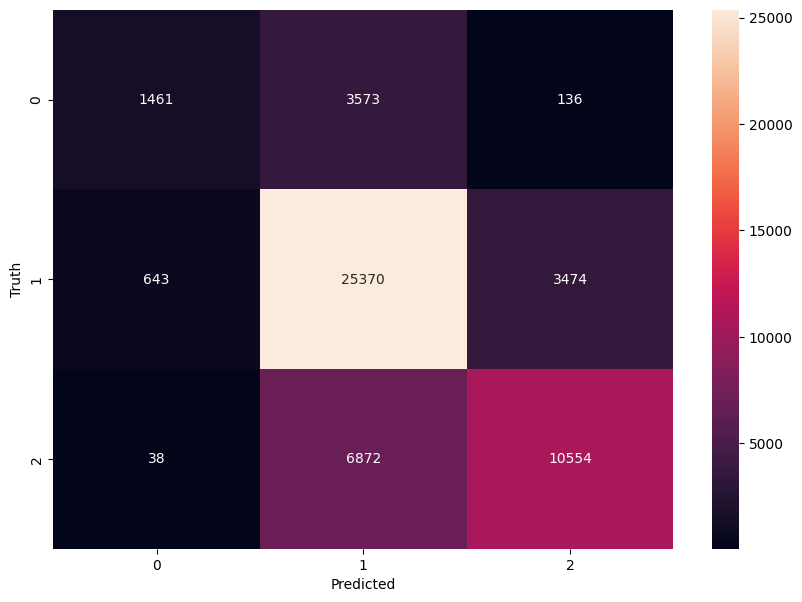

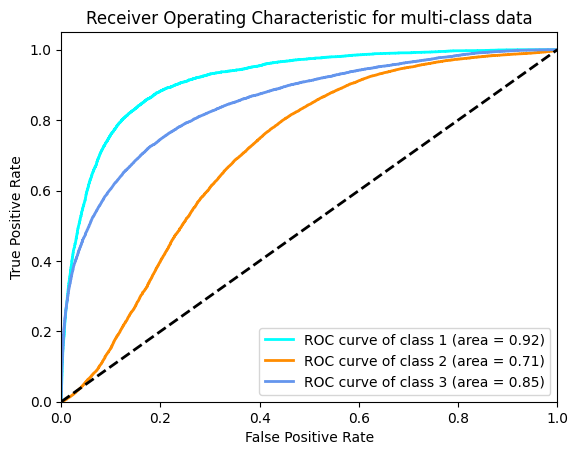

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy)

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix: \n", cm)

# Calculate other performance metrics
report = classification_report(y_test, predictions)
print("Classification Report: \n", report)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Generate classification report
report = classification_report(y_test, predictions)
print("Classification Report: \n", report)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output
y_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [26]:
classifiers = []
for i in range(3):
    logreg = LogisticRegression(penalty='l2', solver='saga')
    grid_search = GridSearchCV(estimator=logreg, param_grid=parameters, cv=5, scoring='accuracy')
    grid_search.fit(X_reg_train, y_train_bin[:, i])
    classifiers.append(grid_search.best_estimator_)

    # Print the optimal C value and corresponding accuracy
    print(f"For class {i+1}, the optimal C value is: ", grid_search.best_params_["C"])
    print(f"The corresponding accuracy is: ", grid_search.best_score_)

# For a new input x, choose the class i that maximizes pˆi(x) as the prediction result
probabilities = np.array([clf.predict_proba(X_reg_test)[:, 1] for clf in classifiers]).T
predictions = np.argmax(probabilities, axis=1) + 1

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy of logistic regression: ", accuracy)

For class 1, the optimal C value is:  10
The corresponding accuracy is:  0.9216087874136608
For class 2, the optimal C value is:  0.001
The corresponding accuracy is:  0.6969589409056025
For class 3, the optimal C value is:  0.01
The corresponding accuracy is:  0.8011415963161935
Accuracy of logistic regression:  0.7172157095988181


Accuracy:  0.7172157095988181
Confusion Matrix: 
 [[ 1395  3634   141]
 [  610 25455  3422]
 [   28  6904 10532]]
Classification Report: 
               precision    recall  f1-score   support

           1       0.69      0.27      0.39      5170
           2       0.71      0.86      0.78     29487
           3       0.75      0.60      0.67     17464

    accuracy                           0.72     52121
   macro avg       0.71      0.58      0.61     52121
weighted avg       0.72      0.72      0.70     52121

Classification Report: 
               precision    recall  f1-score   support

           1       0.69      0.27      0.39      5170
           2       0.71      0.86      0.78     29487
           3       0.75      0.60      0.67     17464

    accuracy                           0.72     52121
   macro avg       0.71      0.58      0.61     52121
weighted avg       0.72      0.72      0.70     52121



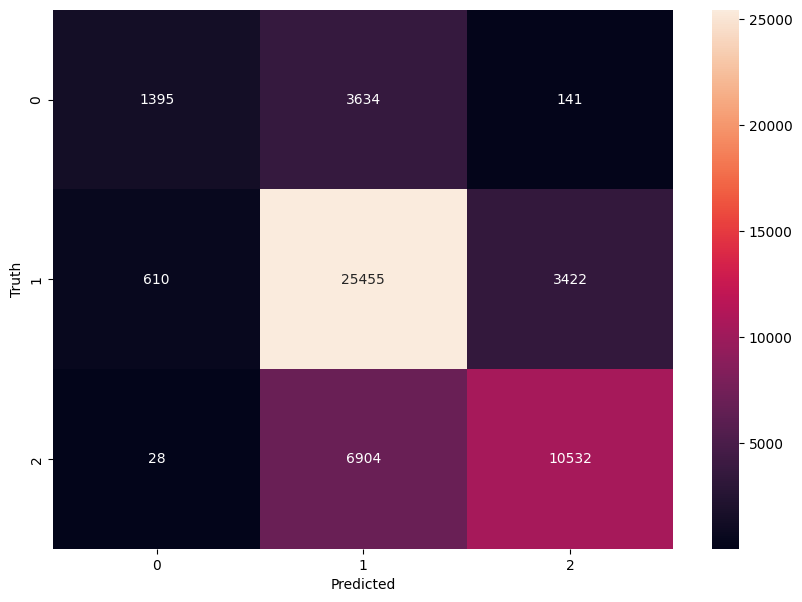

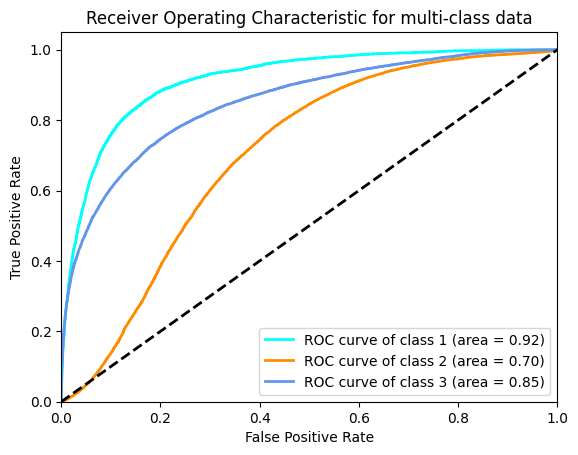

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy)

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix: \n", cm)

# Calculate other performance metrics
report = classification_report(y_test, predictions)
print("Classification Report: \n", report)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Generate classification report
report = classification_report(y_test, predictions)
print("Classification Report: \n", report)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output
y_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### KNN

In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

k_values = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}

knn = KNeighborsRegressor()
knn_regressor = GridSearchCV(knn, k_values, scoring='neg_mean_squared_error', cv=5)
knn_regressor.fit(X_reg_train, y_train)

print("Best K: ", knn_regressor.best_params_)
print("Best mse: ", knn_regressor.best_score_)
knn_predictions = knn_regressor.predict(X_reg_test)
knn_predictions_rounded = np.round(knn_predictions).astype(int)
accuracy = accuracy_score(y_test, knn_predictions_rounded)
print("Accuracy of KNN: ", accuracy)

Best K:  {'n_neighbors': 15}
Best mse:  -0.2134042594013814
Accuracy of KNN:  0.7216285182555976


### FFNN

In [ ]:
ffnn_x_train = np.hstack((np.asarray(X_class_train),geos_train))
ffnn_x_test = np.hstack((np.asarray(X_class_test),geos_test))
print(ffnn_x_train.shape)
print(ffnn_x_test.shape)

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from keras.regularizers import l1 
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
space = {
    'dropout': hp.uniform("dropout",0.7,1),
    'layer': hp.quniform("layer",1,5,1),
    'size': hp.quniform("size",128,512,4)
}
# weights = compute_class_weight("balanced",classes=np.unique(y_train), y=y_train)
# weights = dict(enumerate(weights))
# print(weights)
def ffnn_objective(space):
    model = Sequential()
    size = int(space["size"])
    model.add(Dense(size, activation='relu', input_dim=ffnn_x_train.shape[1]))
    model.add(Dropout(space['dropout']))
    for i in range(int(space['layer'])):
        model.add(Dense(size, activation='relu'))
        model.add(Dropout(space['dropout']))
    model.add(Dense(y_dummy.shape[1], activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    ffnn_model = Pipeline([('ffnn', model)])
    scores = []
    X_ptr, X_pte, y_ptr, y_pte = train_test_split(ffnn_x_train, y_dummy_train,test_size=0.2,random_state=42)
    ffnn_model.fit(X_ptr, y_ptr,ffnn__batch_size=4096, ffnn__epochs=50,ffnn__verbose=0)
    y_pred = ffnn_model.predict(X_pte)
    y_pred = np.argmax(y_pred, axis=1)
    y_pte = np.argmax(y_pte, axis=1)
    ap = f1_score(y_pte,y_pred,average="micro")

    return {'loss': -ap, 'status': STATUS_OK}
# trials = Trials()
# ffnn_best = fmin(fn=ffnn_objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# print("FFNN Best hyperparameters:", ffnn_best)

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(0.9)
# pca.fit(X_class_train)
# ffnn_x_train = pca.transform(X_class_train)
# ffnn_x_test = pca.transform(X_class_test)
# space = {'dropout': 0.8013874158272245, 'layer': 1.0, 'size': 500.0}
# model = Sequential()
# size = int(space["size"])
# model.add(Dense(size, activation='relu', input_dim=ffnn_x_train.shape[1]))
# model.add(Dropout(space['dropout']))
# for i in range(int(space['layer'])):
#     model.add(Dense(size, activation='relu'))
#     model.add(Dropout(space['dropout']))
# model.add(Dense(y_dummy.shape[1], activation='softmax'))
# # optimizer = Adam(learning_rate=0.0001)
# model.compile(loss='categorical_crossentropy',
#               optimizer="adam",metrics=['accuracy'])
# model.fit(ffnn_x_train,y_dummy_train,batch_size=4096,epochs=100)
# ffnn_y_pred_prob = model.predict(ffnn_x_test)
ffnn_y_pred_prob = pd.read_csv("/kaggle/input/esqk-ffnn-res/ffnn_y_pred_prob_te.csv").iloc[:,1:]
# pd.DataFrame(ffnn_y_pred_prob).to_csv("ffnn_y_pred_prob_te.csv")
y_pred = np.argmax(ffnn_y_pred_prob, axis=1)
ffnn_y_test = np.argmax(y_dummy_test, axis=1)
print(confusion_matrix(ffnn_y_test,y_pred))
print(f1_score(ffnn_y_test,y_pred,average="micro"))

## 测试集处理

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold

dt_x_train = np.hstack((np.asarray(X_class_train),geos_train))
dt_x_test = np.hstack((np.asarray(X_class_test),geos_test))

# dt_model = DecisionTreeClassifier(random_state = 1)

# cv = GridSearchCV(dt_model, param_grid={'max_depth': [i for i in range(1, 15)]},
#                   cv=StratifiedKFold(n_splits=5, shuffle=False), scoring='f1_micro')

# cv.fit(dt_x_train, y_train)
# print(cv.best_params_)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score

best_max_dt = DecisionTreeClassifier(max_depth=10,random_state = 1)
best_max_dt.fit(dt_x_train, y_train)
dt_y_pred = best_max_dt.predict(dt_x_test)
print(confusion_matrix(y_test,dt_y_pred))
print(f1_score(y_test,dt_y_pred,average="micro"))

### Random Forest

In [ ]:
# from cuml.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV,StratifiedKFold

rf_x_train = np.hstack((np.asarray(X_class_train),geos_train))
rf_x_test = np.hstack((np.asarray(X_class_test),geos_test))

rf_x_train = rf_x_train.astype('float32')
rf_x_train = rf_x_train.astype('float32')

# rf_model = RandomForestClassifier(random_state = 1,n_streams=2)

# cv = GridSearchCV(rf_model, param_grid={'max_depth': [i for i in range(1, 15)], 'n_estimators': [i for i in range(50,301,50)]},
#                   cv=StratifiedKFold(n_splits=5, shuffle=False), scoring='f1_micro',n_jobs=-1)

# cv.fit(rf_x_train, y_train)
# print(cv.best_params_)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
best_rf_model = RandomForestClassifier(random_state = 1,max_depth = 14, n_estimators = 100)
best_rf_model.fit(rf_x_train, y_train)
rf_y_pred = best_rf_model.predict(rf_x_test)
print(confusion_matrix(y_test,rf_y_pred))
print(f1_score(y_test,rf_y_pred,average="micro"))

In [ ]:
# test data

# test_values = pd.read_csv("/kaggle/input/earthquake-classification/test_values.csv")

# test_dummy_values_reg = pd.get_dummies(data=test_values, columns=categorical_str_columns, drop_first=True, sparse=True)
# test_dummy_values_reg_standard = standardizer_reg.transform(data=test_dummy_values_reg)

# test_dummy_values_class = pd.get_dummies(data=test_values, columns=categorical_str_columns, drop_first=False, sparse=True)
# test_dummy_values_class_standard = standardizer_class.transform(data=test_dummy_values_class)

### LGBM

In [ ]:
import lightgbm as lgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error, f1_score

In [ ]:
# data prepare
lgbm_x_train = np.hstack((np.asarray(X_class_train),geos_train))
lgbm_x_test = np.hstack((np.asarray(X_class_test),geos_test))

lgbm_y_train = y_train - 1
lgbm_y_test = y_test - 1

In [ ]:
space_lgbm = {"num_leaves": hp.quniform("num_leavse", 10, 80, 10),
             "learning_rate": hp.uniform("learning_rate", 0.001, 0.1),
             "feature_fraction": hp.uniform("feature_fraction", 0.5, 1),
             "num_round": hp.quniform("num_round", 70, 150, 10)}

In [ ]:
def lgbm_parameter_select(space):
    
    params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 3,  # 设置为你的类别数量
    'num_leaves': int(space["num_leaves"]),
    'learning_rate': space["learning_rate"],
    'feature_fraction': space["feature_fraction"]
    }

    num_round = int(space["num_round"])  # 树的数量
    
    X_ptr, X_pte, y_ptr, y_pte = train_test_split(lgbm_x_train, lgbm_y_train,test_size=0.2,random_state=42)
    
    train_dataset_lstm = lgb.Dataset(X_ptr, label=y_ptr)
    test_dataset_lstm = lgb.Dataset(X_pte, label=y_pte)

    bst = lgb.train(params, train_dataset_lstm, num_round, valid_sets=[test_dataset_lstm], early_stopping_rounds=10) 
    
    y_pred_lstm = bst.predict(X_pte, num_iteration=bst.best_iteration).argmax(axis=1)
    
    score = f1_score(y_pte, y_pred_lstm, average='macro')
    return {"loss": score, "status": STATUS_OK}

In [ ]:
trials_lgbm = Trials()
best_lgbm = fmin(lgbm_parameter_select, space_lgbm, algo=tpe.suggest, max_evals=100, trials=trials_lgbm, show_progressbar=False)

# best_lgbm

In [ ]:
# process the test result

data_dict = {"loss" : [t['result']['loss'] for t in trials_lgbm.trials],
 "num_leavse": [t['misc']['vals']['num_leavse'][0] for t in trials_lgbm.trials],
 "learning_rate": [t['misc']['vals']['learning_rate'][0] for t in trials_lgbm.trials],
 "feature_fraction": [t['misc']['vals']["feature_fraction"][0] for t in trials_lgbm.trials],
 "num_round": [t['misc']['vals']["num_round"][0] for t in trials_lgbm.trials]}


df_error_lgbm = pd.DataFrame(data=data_dict)

df_error_lgbm.to_csv("/kaggle/working/df_error_lgbm.csv")

#### lgbm visualization

In [ ]:
def scatter_3d(data, x_label: str, y_label: str, z_label: str="loss"):
    x = ddata[x_label]
    y = data[y_label]
    z = data[z_label]

    trace = go.Scatter3d(x=x, y=y, z=z, mode="markers",
                            marker=dict(size=10,
                                        color=z,  # 将颜色与Z轴的值关联
                                        colorscale='Viridis',  # 选择颜色比例尺
                                        colorbar=dict(title=z_label),  # 显示颜色条
                                        opacity=0.8))
    
    
    layout = go.Layout(margin=dict(l=0, r=0, b=0,t=0), 
                  scene=dict(xaxis=dict(title=x_label), yaxis={"title":y_label}, zaxis={"title":z_label}))
    
    fig = go.Figure(data=[trace], layout=layout)
    
    iplot(fig)
    pass

In [ ]:
scatter_3d(df_error_lgbm, "feature_fraction", "num_leavse")

In [ ]:
scatter_3d(df_error_lgbm, "learning_rate", "num_round")

## 数据保存

In [ ]:
# train_dummy_values_reg_standard.to_csv("/kaggle/working/train_values_reg_processed")
# train_dummy_values_class_standard.to_csv("/kaggle/working/train_values_class_processed")

# test_dummy_values_reg_standard.to_csv("/kaggle/working/test_values_reg_processed")
# test_dummy_values_class_standard.to_csv("/kaggle/working/test_values_class_processed")